# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109A Introduction to Data Science

## Standard Section 7: Bagging and Random Forest

**Harvard University**<br/>
**Fall 2019**<br/>
**Instructors**: Pavlos Protopapas, Kevin Rader, and Chris Tanner<br/>
**Section Leaders**: Marios Mattheakis, Abhimanyu (Abhi) Vasishth, Robbert (Rob) Struyven<br/>

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

This section will work with a spam email dataset. Our ultimate goal is to be able to build models so that we can predict whether an email is spam or not spam based on word characteristics within each email. We will cover Decision Trees, Bagging, and Random Forest methods and allow you to apply it to the homework.

Specifically, we will: 
    
    1. Load in the spam dataset and split the data into train and test.
    2. Find the optimal depth for the Decision Tree model and evaluate performance.
    3. Fit the Bagging model using multiple bootstrapped datasets and do majority voting. 
    4. Fit the Random Forest Model and compare with Bagging.
    
Hopefully after this section you will be able to answer the following questions: 
 - What are decision tree models?
 - How do we construct them?
 - How do we visualize them?
 - What is bagging?
 - Why does bagging help with overfitting?
 - Why does bagging help to built more expressive trees?

---------

#### The Idea: Decision Trees are just flowcharts and interpretable!

<img src="data/flowchart.png" alt="how to fix anything" width="70%"/>


It turns out that simple flow charts can be formulated as mathematical models for classification and these models have the properties we desire;
 - interpretable by humans 
 - have sufficiently complex decision boundaries 
 - the decision boundaries are locally linear, each component of the decision boundary is simple to describe mathematically. 


----------

#### Let's review some theory: 

#### How to build Decision Trees (the Learning Algorithm in words): 
To learn a decision tree model, we take a greedy approach: 
 1. Start with an empty decision tree (undivided feature space) 
 2. Choose the ‘optimal’ predictor on which to split and choose the ‘optimal’ threshold value for splitting by applying a **splitting criterion (1)**
 3. Recurse on on each new node until **stopping condition (2)** is met
 
For classification, we label each region in the model with the label of the class to which the majority of the points within the region belong. 

#### So we need a (1) splitting criterion and a (2) stopping condition:

  #### (1) Splitting criterion 
<img src="data/split1.png" alt="split1" width="70%"/>

---
<img src="data/split2.png" alt="split2" width="70%"/>

#### (2) Stopping condition

If we don’t terminate the decision tree learning algorithm manually, the tree will continue to grow until each region defined by the model possibly contains exactly one training point (and the model attains 100% training accuracy). **Not stopping while building a deeper and deeper tree = 100% training accuracy; What will your test accuracy be? What can we do to fix this?**

To prevent the **overfitting** from happening, we could 
- Stop the algorithm at a particular depth. (=**not too deep**)
- Don't split a region if all instances in the region belong to the same class. (=**stop when subtree is pure**)
- Don't split a region if the number of instances in the sub-region will fall below pre-defined threshold (min_samples_leaf). (=**not too specific/small subtree**)
- Don't use to many splits in the tree (=**not too many splits / not too complex global tree**)
- Be content with <100% accuracy training set...

-------------

#### Done with theory, let's get started

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
%matplotlib inline

pd.set_option('display.width', 1500)
pd.set_option('display.max_columns', 100)

from sklearn.model_selection import learning_curve


-------------

# Part 1 : Introduction to the Spam Dataset

We will be working with a spam email dataset. The dataset has 57 predictors with a response variable called `Spam` that indicates whether an email is spam or not spam. The goal is to be able to create a classifier or method that acts as a spam filter.

In [3]:
#Import Dataframe and Set Column Names
spam_df = pd.read_csv('data/spam.csv', header=None)
columns = ["Column_"+str(i+1) for i in range(spam_df.shape[1]-1)] + ['Spam']
spam_df.columns = columns
display(spam_df.head())

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13,Column_14,Column_15,Column_16,Column_17,Column_18,Column_19,Column_20,Column_21,Column_22,Column_23,Column_24,Column_25,Column_26,Column_27,Column_28,Column_29,Column_30,Column_31,Column_32,Column_33,Column_34,Column_35,Column_36,Column_37,Column_38,Column_39,Column_40,Column_41,Column_42,Column_43,Column_44,Column_45,Column_46,Column_47,Column_48,Column_49,Column_50,Column_51,Column_52,Column_53,Column_54,Column_55,Column_56,Column_57,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.0,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


The predictor variabes are all continuous. They represent certain features like the frequency of the word "`discount`". The exact specification and description of each predictor can be found online. We are not so much interested in the exact inference of each predictor so we will omit the exact names of each of the predictors. We are more interested in the prediction of the algorithm so we will treat each as predictor without going into too much exact detail in each.  

Link to description : https://archive.ics.uci.edu/ml/datasets/spambase

Let us split the dataset into a 70-30 split by using the following:

**Note :** While you will use ```train_test_split``` in your homeworks, the code below should help you visualize splitting/masking of a dataframe which will be helpful in general.

In [4]:
#Split data into train and test
np.random.seed(42)
msk = np.random.rand(len(spam_df)) < 0.7
data_train = spam_df[msk]
data_test = spam_df[~msk]

#Split predictor and response columns
x_train, y_train = data_train.drop(['Spam'], axis=1), data_train['Spam']
x_test , y_test  = data_test.drop(['Spam'] , axis=1), data_test['Spam']

print("Shape of Training Set :",data_train.shape)
print("Shape of Testing Set :" ,data_test.shape)

Shape of Training Set : (3262, 58)
Shape of Testing Set : (1339, 58)


In [5]:
spam_df.iloc[np.arange(10)]

,Column_1,Column_2,Column_3,Column_4,Column_5,Column_6,Column_7,Column_8,Column_9,Column_10,Column_11,Column_12,Column_13,Column_14,Column_15,Column_16,Column_17,Column_18,Column_19,Column_20,Column_21,Column_22,Column_23,Column_24,Column_25,Column_26,Column_27,Column_28,Column_29,Column_30,Column_31,Column_32,Column_33,Column_34,Column_35,Column_36,Column_37,Column_38,Column_39,Column_40,Column_41,Column_42,Column_43,Column_44,Column_45,Column_46,Column_47,Column_48,Column_49,Column_50,Column_51,Column_52,Column_53,Column_54,Column_55,Column_56,Column_57,Spam
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,0.00,0.64,0.00,0.00,0.00,0.32,0.00,1.29,1.93,0.00,0.96,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,0.21,0.79,0.65,0.21,0.14,0.14,0.07,0.28,3.47,0.00,1.59,0.0,0.43,0.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.07,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,0.38,0.45,0.12,0.00,1.75,0.06,0.06,1.03,1.36,0.32,0.51,0.0,1.16,0.06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.06,0.0,0.0,0.12,0.00,0.06,0.06,0.0,0.0,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,0.31,0.31,0.31,0.00,0.00,0.31,0.00,0.00,3.18,0.00,0.31,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1
5,0.00,0.00,0.00,0.0,1.85,0.00,0.00,1.85,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.223,0.0,0.000,0.000,0.000,3.000,15,54,1
6,0.00,0.00,0.00,0.0,1.92,0.00,0.00,0.00,0.00,0.64,0.96,1.28,0.00,0.00,0.00,0.96,0.00,0.32,3.85,0.00,0.64,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.054,0.0,0.164,0.054,0.000,1.671,4,112,1
7,0.00,0.00,0.00,0.0,1.88,0.00,0.00,1.88,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.00,0.206,0.0,0.000,0.000,0.000,2.450,11,49,1
8,0.15,0.00,0.46,0.0,0.61,0.00,0.30,0.00,0.92,0.76,0.76,0.92,0.00,0.00,0.00,0.00,0.00,0.15,1.23,3.53,2.00,0.0,0.00,0.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.15,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.30,0.00,0.00,0.00,0.0,0.0,0.00,0.271,0.0,0.181,0.203,0.022,9.744,445,1257,1
9,0.06,0.12,0.77,0.0,0.19,0.32,0.38,0.00,0.06,0.00,0.00,0.64,0.25,0.00,0.12,0.00,0.00,0.12,1.67,0.06,0.71,0.0,0.19,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.00,0.06,0.00,0.00,0.0,0.0,0.04,0.030,0.0,0.244,0.081,0.000,1.729,43,749,1


We can check that the number of spam cases is roughly evenly represented in both the training and test set.

In [6]:
#Check Percentage of Spam in Train and Test Set
percentage_spam_training = 100*y_train.sum()/len(y_train)
percentage_spam_testing  = 100*y_test.sum()/len(y_test)
                                                  
print("Percentage of Spam in Training Set \t : {:0.2f}%.".format(percentage_spam_training))
print("Percentage of Spam in Testing Set \t : {:0.2f}%.".format(percentage_spam_testing))

Percentage of Spam in Training Set 	 : 39.18%.
Percentage of Spam in Testing Set 	 : 39.96%.


-----------

# Part 2 : Fitting an Optimal Single Decision Tree (by Depth) :

We fit here a single tree to our spam dataset and perform 5-fold cross validation on the training set. For EACH depth of the tree, we fit a tree and then compute the 5-fold CV scores. These scores are then averaged and compared across different depths. 

In [7]:
#Find optimal depth of trees
mean_CV_acc = {}
all_CV_acc = {}
tree_depth_start, tree_depth_end, steps = 3, 31, 4
for i in range(tree_depth_start, tree_depth_end, steps):
    model = DecisionTreeClassifier(max_depth=i)
    score = cross_val_score(estimator=model, X=x_train, y=y_train, cv=5, n_jobs=-1)
    all_CV_acc[i] = score
    mean_CV_acc[i] = score.mean()

In [8]:
mean_CV_acc

{3: 0.8764041147790251,
 7: 0.8975721524522913,
 11: 0.888674076520091,
 15: 0.8883696739306298,
 19: 0.8813130326307494,
 23: 0.8846891534291315,
 27: 0.8810124010508662}

Some dictionary manipulations for our x,y construction for the plot below:

In [18]:
x = list(mean_CV_acc.keys())
y = list(mean_CV_acc.values())
x,y

([3, 7, 11, 15, 19, 23, 27],
 [0.8764041147790251,
  0.8975721524522913,
  0.888674076520091,
  0.8883696739306298,
  0.8813130326307494,
  0.8846891534291315,
  0.8810124010508662])

In [19]:
lists = sorted(mean_CV_acc.items())
x, y = zip(*lists) 
x,y

((3, 7, 11, 15, 19, 23, 27),
 (0.8764041147790251,
  0.8975721524522913,
  0.888674076520091,
  0.8883696739306298,
  0.8813130326307494,
  0.8846891534291315,
  0.8810124010508662))

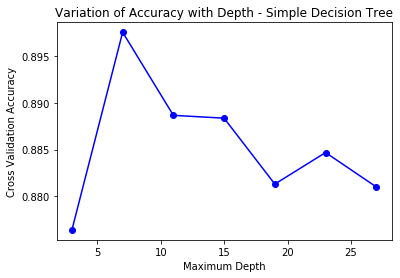

In [11]:
#Plot
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

As we can see, the optimal depth is found to be a depth of 7. Although, does it makes sense to choose 6?

Also, if we wanted to get the Confidence Bands of these results, how would we? It's as simple as a combination of getting variance using ```scores.std()``` and ```plt.fill_between()```.

In [12]:
stds = np.array([ np.std(score) for score in all_CV_acc.values() ])
stds

array([0.05196923, 0.03787334, 0.0444573 , 0.04818929, 0.05285347,
       0.05054034, 0.04774893])

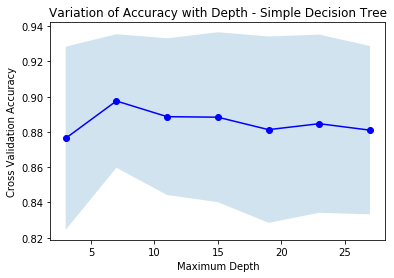

In [13]:
plt.fill_between(x, y + stds, y - stds, alpha=0.2)

#Plot
plt.ylabel("Cross Validation Accuracy")
plt.xlabel("Maximum Depth")
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
plt.plot(x, y, 'b-', marker='o')
plt.show()

If we want to display it as a boxplot we first construct a dataframe with all the scores and second we use ```sns.boxplot(...)```

In [14]:
# Making a numpy array with all the CV acc scores
scores_numpy = np.array(list(all_CV_acc.values()))
# Making a datafr
trees = pd.DataFrame({'Max Depth':x+x+x+x+x, 'CV Accuracy Score':list(scores_numpy[:,0])+
                     list(scores_numpy[:,1])+
                     list(scores_numpy[:,2])+
                     list(scores_numpy[:,3])+
                     list(scores_numpy[:,4])})
trees.head()

,Max Depth,CV Accuracy Score
0,3,0.915773
1,7,0.911179
2,11,0.908116
3,15,0.903522
4,19,0.894334


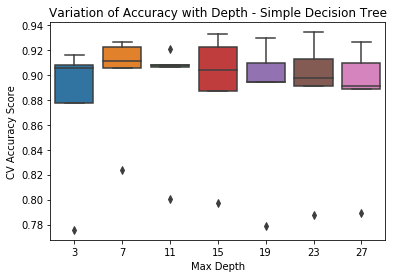

In [15]:
# plotting the boxplot 
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
sns.boxplot(x="Max Depth", y="CV Accuracy Score", data=trees);

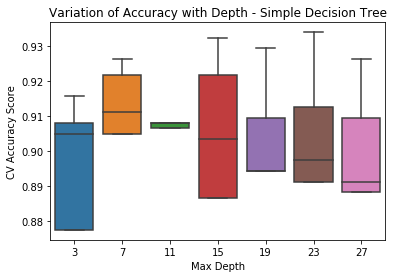

In [16]:
# plotting the boxplot without outliers (showfliers = False)
plt.title('Variation of Accuracy with Depth - Simple Decision Tree')
sns.boxplot(x="Max Depth", y="CV Accuracy Score", data=trees, showfliers=False);

**Let's extract the best_depth value from this dictionary:** 

We create the new variable ```best_depth```. Can you see why we coded the best depth parameter as we did below? (Hint: Think about reproducibility.)

How to sort using your own function with key parameter?
If you want your own implementation for sorting, sorted() also accepts a key function as an optional parameter.

Based on the results of the key function, you can sort the given iterable.

```sorted(iterable, key=len)```

In [20]:
# What does this do? Is this the result we want?
sorted(mean_CV_acc, reverse=True)

[27, 23, 19, 15, 11, 7, 3]

In [21]:
# What does this do?
sorted(mean_CV_acc, key=mean_CV_acc.get, reverse=True)

[7, 11, 15, 23, 19, 27, 3]

In [22]:
#Make best depth a variable
best_depth = sorted(mean_CV_acc, key=mean_CV_acc.get, reverse=True)[0]
print("The best depth was found to be:", best_depth)

The best depth was found to be: 7


In [ ]:
#Evalaute the performance at the best depth
model_tree = DecisionTreeClassifier(max_depth=best_depth)
model_tree.fit(x_train, y_train)

#Check Accuracy of Spam Detection in Train and Test Set
acc_trees_training = accuracy_score(y_train, model_tree.predict(x_train))
acc_trees_testing  = accuracy_score(y_test,  model_tree.predict(x_test))

print("Simple Decision Trees: Accuracy, Training Set \t : {:.2%}".format(acc_trees_training))
print("Simple Decision Trees: Accuracy, Testing Set \t : {:.2%}".format(acc_trees_testing))

In [ ]:
#Get Performance by Class (Lookup Confusion Matrix)
pd.crosstab(y_test, model_tree.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])

#### How to visualize a Decision Tree with ```pydot```

*Question:* Do you think this tree is interpretable? What do you think about a the maximal depth of the tree?

- Let's first store the decision tree in a text format: ```decision_tree.dot```

In [ ]:
from sklearn import tree

file_name = "results/decision_tree.dot"
tree.export_graphviz(model_tree, out_file = file_name) 

- Let's look at the resulting text ```decision_tree.dot```

In [ ]:
! head results/decision_tree.dot

- Let's convert our (hard to read) written decision tree (```decision_tree.dot```) into an intuitive image file format: ```image_tree.png```
- <span style="color:red">**NOTE:**</span> You might need to install the ```pydot``` package by typing the following command in your terminal: ```pip install pydot``` or you can install from within the jupyter notebook by running the following cell: ```! pip install pydot```

In [ ]:
! pip install pydot
! conda install graphviz -y

In [ ]:
import pydot
(graph,) = pydot.graph_from_dot_file(file_name)
graph.write_png('results/image_tree.png')

- Let's display the ```image_tree.png``` in markdown:

Markdown: ```![title](results/image_tree.png)```. The result: 

![title](results/image_tree.png)

*Repost Question:* Do you think this tree is interpretable?


--------


# Part 3: Bagging and Voting

*QUESTION:* Where does the word *"Bagging"* come from?

#### Some Theory: What is bagging?
  1. Bootstrapping: resample with replacements to get different datasets and built different models.
  2. Do something smart to combine the different models.
  
One way to adjust for the high variance of the output of an experiment is to perform the experiment multiple times and then average the results. 

 1. **Bootstrap:** we generate multiple samples of training data, via bootstrapping. We train a full decision tree on each sample of data. 
 2. **AGgregatiING** for a given input, we output the averaged outputs of all the models for that input. 
 
This method is called **Bagging: B** ootstrap + **AGG**regat**ING**. 

-----------

Let's bootstrap our training dataset to create multiple datasets and fit Decision Tree models to each.

(Resampling: we showed live that different samples give different results for things like sums, varying more when the things we sum over have high variance themselves.)

In [ ]:
# Stat on all data
data_train.mean(axis=0).to_frame('mean').T

In [ ]:
data_train.sample(frac=1., replace=True).mean(axis=0).to_frame('mean').T

Now we actually fit the samples

In [ ]:
n_trees = 100 # we tried a variety of numbers here
choosen_depth = 5

In [ ]:
#Creating model
np.random.seed(0)
model = DecisionTreeClassifier(max_depth=choosen_depth)

#Initializing variables
predictions_train = np.zeros((data_train.shape[0], n_trees))
predictions_test = np.zeros((data_test.shape[0], n_trees))

#Conduct bootstraping iterations
for i in range(n_trees):
    temp = data_train.sample(frac=1, replace=True)
    response_variable = temp['Spam']
    temp = temp.drop(['Spam'], axis=1)
    
    model.fit(temp, response_variable)  
    predictions_train[:,i] = model.predict(x_train)   
    predictions_test[:,i] = model.predict(x_test)
    
#Make Predictions Dataframe
columns = ["Bootstrap-Model_"+str(i+1) for i in range(n_trees)]
predictions_train = pd.DataFrame(predictions_train, columns=columns)
predictions_test = pd.DataFrame(predictions_test, columns=columns)

In [ ]:
y_train = data_train['Spam'].values
y_test = data_test['Spam'].values

In [ ]:
## Example Bolean for locating the Non Spam
y == 0
## Example Bolean for locating the Spam
y == 1

In [ ]:
num_to_avg = 100
fig, axs = plt.subplots(1, 2, figsize=(16, 7))
for (ax, label, predictions, y) in [
    (axs[0], 'Training Set', predictions_train, y_train), 
    (axs[1], 'Test Set' , predictions_test , y_test ) ]:
    
    # Take the average
    mean_predictions = predictions.iloc[:,:num_to_avg].mean(axis=1)
    
    # Plot the Spam
    mean_predictions[y == 1].hist(density=True, histtype='step', 
                                  range=[0,1], label='Spam', lw=2, ax=ax)
    
    # Plot the non Spam
    mean_predictions[y == 0].hist(density=True, histtype='step', 
                                  range=[0,1], label='Not-Spam', lw=2, ax=ax)
    ax.legend(loc='upper center');
    ax.set_xlabel("Mean of ensemble predictions (0.5=50 True - 50 False)")
    ax.set_title(label)


And now get final predictions: majority voting!

In [ ]:
#Function to ensemble the prediction of each bagged decision tree model
def get_prediction(df, count=-1):
    count = df.shape[1] if count==-1 else count
    temp = df.iloc[:,0:count]
    return np.mean(temp, axis=1)>0.5

#Check Accuracy of Spam Detection in Train and Test Set
acc_bagging_training = 100*accuracy_score(y_train, get_prediction(predictions_train, count=-1))
acc_bagging_testing  = 100*accuracy_score(y_test, get_prediction(predictions_test, count=-1))

print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

Count in the above code can be use to define the number of models the voting in the dataframe should be based on.

In [ ]:
#Get Performance by Class (Lookup Confusion Matrix)
pd.crosstab(np.array(y_test), model.predict(x_test), margins=True, rownames=['Actual'], colnames=['Predicted'])


**Food for Thought :** Are these bagging models independent of each other, can they be trained in a parallel fashion?

# Part 4 : Random Forest vs Bagging

#### What is Random Forest? 

- **Many trees** make a **forest**.
- **Many random trees** make a **random forest**.


Random Forest is a modified form of bagging that creates ensembles of independent decision trees. 
To *de-correlate the trees*, we: 
1. train each tree on a separate bootstrap **random sample** of the full training set (same as in bagging) 
2. for each tree, at each split, we **randomly select a set of 𝐽′ predictors from the full set of predictors.** (not done in bagging)
3. From amongst the 𝐽′  predictors, we select the optimal predictor and the optimal corresponding threshold for the split. 

*Question:* Why would this second step help (only considering random sub-group of features)?

Now, we will fit an ensemble method, the Random Forest technique, which is different from the decision tree. Refer to the lectures slides for a full treatment on how they are different. Let's use ```n_estimators = predictor_count/2``` and ```max_depth = best_depth```.

In [ ]:
#Fit a Random Forest Model

#Training
model = RandomForestClassifier(n_estimators=int(x_train.shape[1]/2), max_depth=best_depth)
model.fit(x_train, y_train)

#Predict
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Perfromance Evaluation
acc_random_forest_training = accuracy_score(y_train, y_pred_train)*100
acc_random_forest_testing = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set : {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: Accuracy, Testing Set :  {:0.2f}%".format(acc_random_forest_testing))

#### Let's compare the performance of our 3 models:

In [ ]:
print("Decision Trees:\tAccuracy, Training Set \t: {:.2%}".format(acc_trees_training))
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))

print("\nBagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))

print("\nRandom Forest: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_random_forest_training))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))

#### As we see above, the performance of both Bagging and Random Forest was similar, so what is the difference? Do both overfit the data just as much?

Hints :

- What is the only extra parameter we declared when defining a Random Forest Model vs Bagging? Does it have an impact on overfitting?

In [ ]:
#Fit a Random Forest Model

new_depth = best_depth + 20 

#Training
model = RandomForestClassifier(n_estimators=int(x_train.shape[1]/2), max_depth=new_depth)
model.fit(x_train, y_train)

#Predict
y_pred_train = model.predict(x_train)
y_pred_test = model.predict(x_test)

#Perfromance Evaluation
acc_random_forest_deeper_training = accuracy_score(y_train, y_pred_train)*100
acc_random_forest_deeper_testing = accuracy_score(y_test, y_pred_test)*100

print("Random Forest: Accuracy, Training Set (Deeper): {:0.2f}%".format(acc_random_forest_deeper_training))
print("Random Forest: Accuracy, Testing Set (Deeper):  {:0.2f}%".format(acc_random_forest_deeper_testing))

#### Training accuracies:

In [ ]:
print("Training Accuracies:")
print("Decision Trees:\tAccuracy, Training Set \t: {:.2%}".format(acc_trees_training))
print("Bagging: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_bagging_training))
print("Random Forest: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_random_forest_training))
print("RF Deeper: \tAccuracy, Training Set \t: {:0.2f}%".format(acc_random_forest_deeper_training))

#### Testing accuracies:

In [ ]:
print("Testing Accuracies:")
print("Decision Trees:\tAccuracy, Testing Set \t: {:.2%}".format(acc_trees_testing))
print("Bagging: \tAccuracy, Testing Set \t: {:0.2f}%".format( acc_bagging_testing))
print("Random Forest: \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_testing))
print("RF Deeper:  \tAccuracy, Testing Set \t: {:0.2f}%".format(acc_random_forest_deeper_testing))

#### Feature Importance
Random Forest gives the above values as ```feature_importance``` where it normalizes the impact of a predictor to the number of times it is useful and thus gives overvall significance for free. Explore the attributes of the Random Forest model object for the best nodes.

In [ ]:
#Top Features
feature_importance = model.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

#Plot
plt.figure(figsize=(10,12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

#### Our Initial Questions:

- What are decision tree models?
- How do we construct them?
- How do we vizualize them?
- What is the idea of bagging?
- Why does bagging help with overfitting?
- Why does bagging help to built more expressive trees?

#### End of Standard Section. What about next week? 

**Gradient Boosting etc.. building upon decision trees. Why should we care?** 

<img src="data/kaggle.png" alt="tree_adj" width="100%"/>


----------
<img src="data/trees_adj.png" alt="tree_adj" width="100%"/>

[Source Medion: "XGBoost Algorithm: Long May She Reign!"](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)